In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot
from keras.callbacks import ReduceLROnPlateau
import keras
import texthero as hero
from texthero import preprocessing as str_preprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Read in and Prepare Data

In [22]:
def encode_and_bind(original_dataframe, feature_to_encode): # utility function for one-hot encoding
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)
    

In [23]:
labels = pd.read_csv ("./gilani-2017/gilani-2017.tsv", sep = '\t')
labels['id'] = labels['461277906']
df = pd.read_json("./gilani-2017/gilani-2017_tweets.json")
df = pd.json_normalize(df['user'])
df.columns = df.columns.map(lambda x: x.split(".")[-1])
df = pd.merge(df,labels,on='id')

df = df.drop(['461277906', 'lang', 'is_translator', 'is_translation_enabled',  'profile_background_tile',  'profile_background_color', 'profile_background_image_url', 'time_zone', 'profile_background_image_url_https', 'id', 'created_at', 'profile_image_url', 'profile_image_url_https', 'utc_offset' , 'url', 'profile_banner_url','protected','name','translator_type', 'urls', 'id_str', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_link_color'], axis = 1)
df.bot = [1 if i == 'bot' else 0 for i in df.bot]
df = df.dropna(axis = 1)
df

,screen_name,location,description,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,contributors_enabled,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,following,follow_request_sent,notifications,bot
0,BaseballQuotes1,The Diamond,Quoting America's Pastime in 280 characters or...,121500,346,532,35894,True,False,21246,False,False,False,False,False,False,False,False,0
1,cavs,"The Q | Cleveland, OH",Official Twitter of the 2016 NBA Champion Clev...,3227215,1946,9039,16134,True,True,45791,False,True,False,False,False,False,False,False,0
2,muohajer_12,المملكة العربية السعودية,,864968,767106,1371,23,True,False,875763,False,True,False,True,False,False,False,False,1
3,Bc20_,,R.I.P JRL21//R.I.P Monica💙 IG//b.20c #GLOHIOBOYS,951,275,9,22147,True,False,88862,False,False,True,False,False,False,False,False,0
4,_Blkahontas,"Hollywood, FL",to die for 🔮🤞🏾👸🏾,1412,623,12,5582,True,False,142073,False,True,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2497,BigMacFlashy,"Phoenix, AZ",CEO of @thebambox and @comiconauction. Love De...,331,154,1,350,False,False,325,False,False,False,False,False,False,False,False,0
2498,BadruulAminn,"Petaling, Selangor",20 / YouTuber + Streamer / Married /\n\nCome s...,71105,62028,27,1818,False,False,27006,False,True,True,False,False,False,False,False,0
2499,anxietyhes,,woke up the girl who looked just like you I al...,99769,67170,335,27192,True,False,81781,False,True,True,False,False,False,False,False,0
2500,EN_owl,なごやちほー,旧型クロスカブ改(プラウダ戦車色)に乗るガルパンおじさん。ノンナと愛里寿推し。日本一周201...,1222,244,102,382,False,False,70120,False,True,False,False,False,False,False,False,1


In [27]:
data = np.asarray(df.drop(['bot'], axis = 1))


custom_pipeline = [str_preprocessing.fillna,
                   str_preprocessing.remove_whitespace,
                   str_preprocessing.remove_diacritics,
                   str_preprocessing.remove_brackets
                  ]

string_cols = ['screen_name', 'location', 'description' ]
for ftr in string_cols:
    df[ftr] = hero.clean(df[ftr], custom_pipeline)

ftrs = ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count']
for ftr in ftrs:
    df[ftr] = (np.array(df[ftr]) - np.mean(df[ftr]))/max(df[ftr])


In [25]:
for ftr in string_cols: #vector encoding
    tokens = [TaggedDocument(doc.split(' '), [i]) 
                for i, doc in enumerate(df[ftr])]
    model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
    model.build_vocab(tokens)
    model.train(tokens, total_examples=model.corpus_count, epochs=model.epochs)
    card2vec = [model.infer_vector((df[ftr][i].split(' '))) 
            for i in range(0,len(df[ftr]))]
    df[ftr] = card2vec
df

KeyboardInterrupt: 

In [29]:
data = df.copy()
data = data.drop(['screen_name', 'location', 'description'] ,axis = 1)
print(data)
ftr_count = len(data.keys())
data = np.asarray(data.drop(['bot'], axis = 1))

# idx =int(len(df)*.7) #70-30 split
# X_train, X_test, Y_train, Y_test = np.array(data[:idx:]), np.array(data[idx:,:]), np.array(df.bot[:idx:]), np.array(df.bot[idx:,:])
# X_train, X_test, Y_train, Y_test = np.array(data[:idx]), np.array(data[idx:]), np.array(df.bot[:idx]), np.array(df.bot[idx:])


X_train, X_test, Y_train, Y_test = train_test_split(data, np.array(df.bot),test_size = 0.3, random_state = 78)
X_train, X_test, Y_train, Y_test = X_train.astype(np.float), X_test.astype(np.float), Y_train.astype(np.float), Y_test.astype(np.float)

      followers_count  friends_count  listed_count  favourites_count  \
0           -0.009569      -0.009499     -0.003988          0.024466   
1            0.019473      -0.008751      0.010039          0.002166   
2           -0.002617       0.348570     -0.002604         -0.016015   
3           -0.010696      -0.009532     -0.004850          0.008952   
4           -0.010692      -0.009369     -0.004845         -0.009742   
...               ...            ...           ...               ...   
2497        -0.010702      -0.009588     -0.004863         -0.015646   
2498        -0.010040       0.019306     -0.004820         -0.013990   
2499        -0.009772       0.021707     -0.004312          0.014646   
2500        -0.010694      -0.009546     -0.004697         -0.015610   
2501        -0.010693      -0.009185     -0.004865          0.028726   

      geo_enabled  verified  statuses_count  contributors_enabled  \
0            True     False       -0.022961                 False 

In [30]:
#RANDOM FOREST
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 3, criterion = 'entropy')
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]
print("ACC: ", sum([1 if i==j else 0  for i,j in zip(y_predict_forest,Y_test) ])/len(y_predict_forest))
# print(classification_report(Y_test, y_predict_forest))

ACC:  0.7163781624500666


In [34]:
#RANDOM FOREST WITH BOOSTING
# Import the model we are using
from xgboost import XGBRFClassifier
rf = XGBRFClassifier(n_estimators=100, use_label_encoder=False, verbose = True)
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]

print("ACC: ", sum([1 if i==j else 0  for i,j in zip(y_predict_forest,Y_test) ])/len(y_predict_forest))


[16:57:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:57:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ACC:  0.7683089214380826


In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100) # tuned to 100
knn.fit(X_train, Y_train)
y_predict_knn = knn.predict(X_test)
y_predict_knn = [1 if i > 0.5 else 0 for i in y_predict_knn]
print("ACC: ", sum([1 if i==j else 0  for i,j in zip(y_predict_knn,Y_test) ])/len(y_predict_knn))

ACC:  0.6644474034620506


In [32]:
#MODELS
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve,
]

def create_model(idim = ftr_count-1):
  model = Sequential()

  model.add(Dense(32, input_dim=idim))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(64, input_dim=32))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(128, input_dim=64))
  model.add(Dropout(.5))
  model.add(Activation('gelu'))


  model.add(Dense(64, input_dim=128))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))
  
  model.add(Dense(32, input_dim=64))
  model.add(Dropout(.1))
  model.add(Activation('gelu'))

  model.add(Dense(1, input_dim=64))
  model.add(Activation('sigmoid'))

  optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3, nesterov=False,
  )
  #tfa.losses.SigmoidFocalCrossEntropy()
  model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model


# class_weight = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = np.array(df.bot).astype(np.float))
# class_weight = {0: class_weight[0],
#                 1: class_weight[1]}
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                512       
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 activation_12 (Activation)  (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 activation_13 (Activation)  (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [33]:

history = model.fit(x=X_train.astype(np.float), y=Y_train.astype(np.float), batch_size=8, epochs=50, validation_data=(X_test.astype(np.float), Y_test.astype(np.float)), verbose=1, shuffle=True, callbacks=
                                [ModelCheckpoint(filepath='./ckpts/best_val_loss.hdf5',
                                               monitor= 'val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=2),
                                EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1),  
                                ReduceLROnPlateau(
                                monitor='loss', factor=0.1, patience=10, verbose=1,
                                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
                            )])

Epoch 1/50
207/219 [===========================>..] - ETA: 0s - loss: 0.6932 - tp: 322.0000 - fp: 421.0000 - tn: 530.0000 - fn: 383.0000 - accuracy: 0.5145 - precision: 0.4334 - recall: 0.4567 - auc: 0.5016 - prc: 0.4140
Epoch 00001: val_loss improved from inf to 0.69332, saving model to ./ckpts/best_val_loss.hdf5
219/219 [==============================] - 5s 9ms/step - loss: 0.6932 - tp: 329.0000 - fp: 435.0000 - tn: 571.0000 - fn: 416.0000 - accuracy: 0.5140 - precision: 0.4306 - recall: 0.4416 - auc: 0.5015 - prc: 0.4135 - val_loss: 0.6933 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 405.0000 - val_fn: 344.0000 - val_accuracy: 0.5393 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4794 - val_prc: 0.4343 - lr: 0.0010
Epoch 2/50
217/219 [============================>.] - ETA: 0s - loss: 0.6914 - tp: 99.0000 - fp: 166.0000 - tn: 829.0000 - fn: 642.0000 - accuracy: 0.5346 - precision: 0.3736 - recall: 0.1336 - auc: 0.4786 - prc: 0.3988
Epoch 00002: val_loss improved

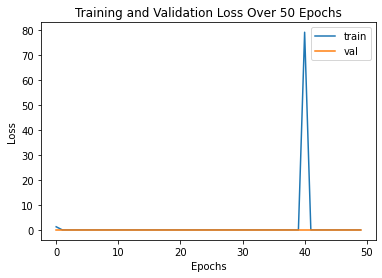

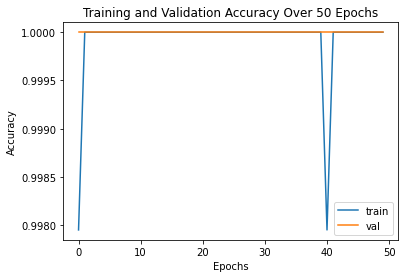

array([[210]])

In [ ]:
history.history['loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

history.history['accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Validation Accuracy Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()
 
from sklearn.metrics import log_loss # The data is binary
from math import sqrt

model.built = True
model.load_weights("ckpts/best_val_loss.hdf5")
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # roc curve when you change threshold
confusion_matrix(y_pred, Y_test)

